In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import Dataset
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
lfw_people = fetch_lfw_people(data_home="/storage/data/zhanghx2023", min_faces_per_person=10,resize=0.4)
#选取样本量量更多的那些人脸，这样会方便训练
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [6]:
lfw_data = pd.DataFrame( lfw_people.data)	
lfw_data['species'] = lfw_people.target_names[lfw_people.target]	
lfw_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1841,1842,1843,1844,1845,1846,1847,1848,1849,species
0,90.0,85.0,128.333328,178.333328,203.000000,211.000000,218.333328,225.333328,229.666672,231.666672,...,52.000000,36.000000,33.333332,32.666668,35.333332,35.666668,33.000000,38.000000,41.000000,Jacques Chirac
1,64.0,108.0,162.666672,201.000000,224.666672,229.333328,229.666672,228.333328,227.333328,229.333328,...,16.666666,4.333333,4.666667,3.333333,1.333333,0.000000,0.333333,3.000000,5.333333,Abdullah Gul
2,107.0,106.0,121.666664,132.666672,141.666672,142.000000,139.666672,136.333328,142.000000,147.000000,...,62.333332,81.333336,95.333336,154.666672,173.333328,174.000000,149.666672,142.333328,157.333328,Serena Williams


Total dataset size:
n_samples: 4324
n_features: 1850
n_classes: 158


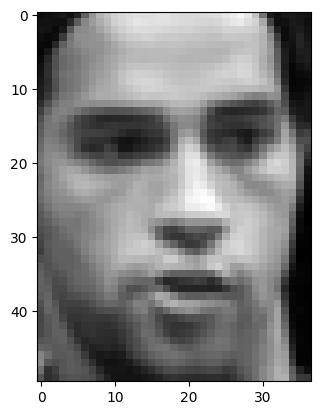

In [7]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

In [8]:
X=StandardScaler().fit_transform(X)
# X=MinMaxScaler().fit_transform(X)

PCA处理后数据形状: (4324, 144)


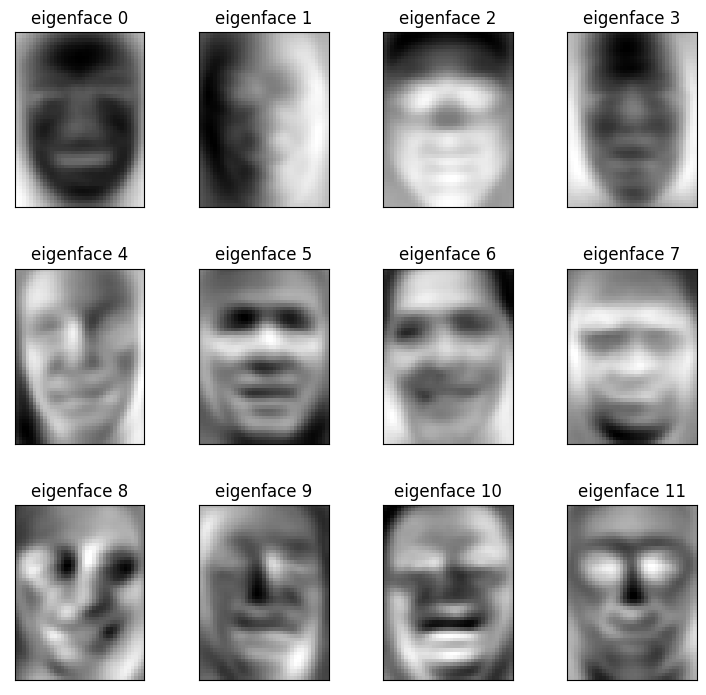

In [9]:
# PCA降维
n_components = 144  # 保留的主成分数量
pca = PCA(n_components=n_components, whiten=True).fit(X)
X_pca = pca.transform(X)

print("PCA处理后数据形状:", X_pca.shape)

# 可视化PCA后的特征脸
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 显示特征脸
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [16]:
X_pca_reshaped = X_pca.reshape(n_samples, 1, 12, 12)  # 将数据reshape为(样本数, 通道数, 高, 宽)

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_reshaped, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# 创建数据加载器
class PCADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_dataset = PCADataset(X_train, y_train)
test_dataset = PCADataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class PCA_AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(PCA_AlexNet, self).__init__()
        # 修改第一层卷积，输入通道改为1
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 修改kernel_size适应12x12输入
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 12->6
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 6->3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # 替换原MaxPool，直接得到1x1
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
# 定义基本的ResNet模块
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    self.expansion * out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PCA_ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(PCA_ResNet18, self).__init__()
        self.in_channels = 64
        
        # 修改第一层卷积，输入通道改为1，kernel_size减小
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 12x12输入
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # 12->6
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # 6->3
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # 3->2 (ceil_mode=True)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # 2->1
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def PCA_ResNet18_with_classes(total_person):
    return PCA_ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=total_person)

In [22]:
# # 初始化模型
# model = PCA_AlexNet(n_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 初始化模型
model = PCA_ResNet18_with_classes(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# 训练函数
def train(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Acc: {100*correct/total:.2f}%')

# 评估函数
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100*correct/total:.2f}%')

# 训练模型
train(model, train_loader, criterion, optimizer, epochs=30)

# 评估模型
evaluate(model, test_loader)

Epoch 1/30 - Loss: 4.6584 - Acc: 13.41%
Epoch 2/30 - Loss: 3.9161 - Acc: 21.19%
Epoch 3/30 - Loss: 3.3388 - Acc: 27.87%
Epoch 4/30 - Loss: 2.6781 - Acc: 37.55%
Epoch 5/30 - Loss: 2.1528 - Acc: 47.07%
Epoch 6/30 - Loss: 1.6570 - Acc: 57.82%
Epoch 7/30 - Loss: 1.3689 - Acc: 64.67%
Epoch 8/30 - Loss: 1.0198 - Acc: 72.88%
Epoch 9/30 - Loss: 1.0611 - Acc: 72.22%
Epoch 10/30 - Loss: 0.6051 - Acc: 83.29%
Epoch 11/30 - Loss: 0.4034 - Acc: 91.30%
Epoch 12/30 - Loss: 0.4099 - Acc: 89.97%
Epoch 13/30 - Loss: 0.3662 - Acc: 91.62%
Epoch 14/30 - Loss: 0.4164 - Acc: 90.23%
Epoch 15/30 - Loss: 0.5261 - Acc: 86.67%
Epoch 16/30 - Loss: 0.5444 - Acc: 85.40%
Epoch 17/30 - Loss: 0.3565 - Acc: 91.82%
Epoch 18/30 - Loss: 0.8114 - Acc: 76.79%
Epoch 19/30 - Loss: 0.7126 - Acc: 80.43%
Epoch 20/30 - Loss: 0.4059 - Acc: 89.65%
Epoch 21/30 - Loss: 0.2524 - Acc: 94.91%
Epoch 22/30 - Loss: 0.3880 - Acc: 90.55%
Epoch 23/30 - Loss: 0.3427 - Acc: 92.83%
Epoch 24/30 - Loss: 0.6090 - Acc: 83.84%
Epoch 25/30 - Loss: 0.404

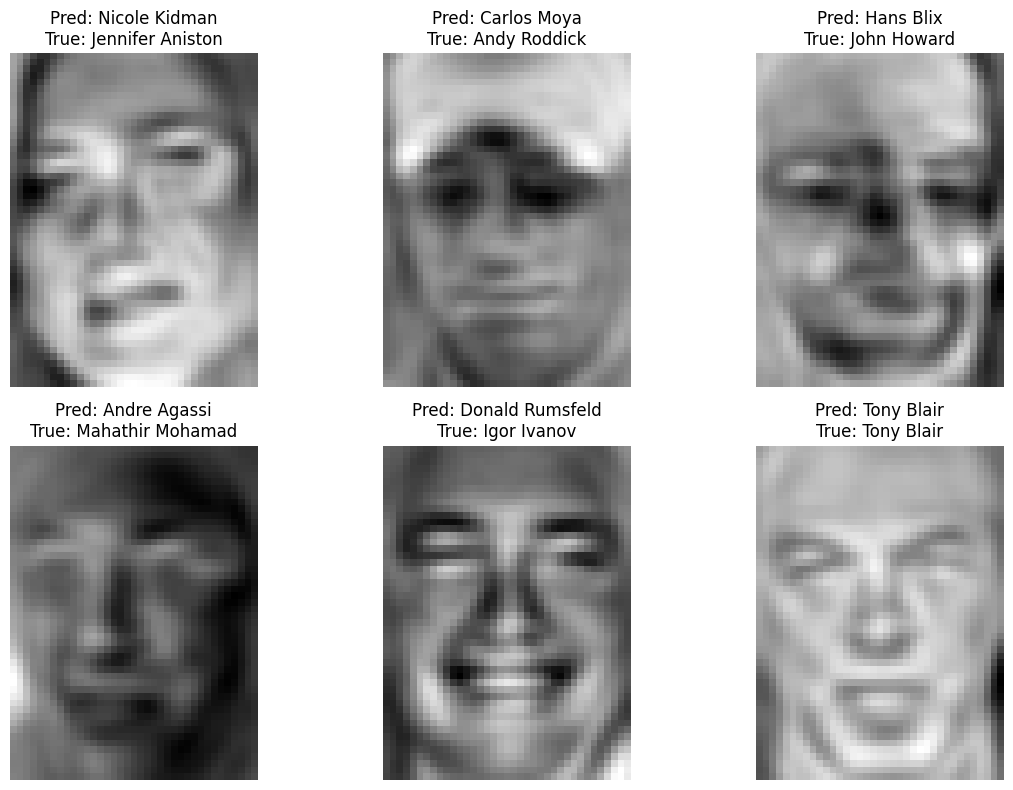

In [21]:
def visualize_pca_predictions(model, test_loader, target_names, pca, n_images=6):
    model.eval()
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(images[:n_images])
        _, preds = torch.max(outputs, 1)
    
    # 将PCA特征反向转换为图像空间
    inverse_images = pca.inverse_transform(images[:n_images].cpu().numpy().reshape(n_images, -1))
    inverse_images = inverse_images.reshape(n_images, h, w)
    
    plt.figure(figsize=(12, 8))
    for i in range(n_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(inverse_images[i], cmap='gray')
        plt.title(f'Pred: {target_names[preds[i]]}\nTrue: {target_names[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_pca_predictions(model, test_loader, target_names, pca)